In [42]:
import os
import glob
import json

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch

In [2]:
import sys
sys.path.append("../")
import TissueLabeling

In [3]:
from TissueLabeling.brain_utils import mapping

In [4]:
matthias_data_path = '/om2/user/sabeen/nobrainer_data_norm/new_med_no_aug_51'
my_data_path = '/om2/user/sabeen/kwyk_data/kwyk_final_crop_1000'
mode = 'train'

In [5]:
matthias_images = sorted(glob.glob(f"{matthias_data_path}/{mode}/brain*.npy"))
matthias_masks = sorted(glob.glob(f"{matthias_data_path}/{mode}/mask*.npy"))

In [6]:
data_size='med'
background_percent_cutoff = 0.8
valid_feature_filename = f"{my_data_path}/{mode}/valid_feature_files_{int(background_percent_cutoff*100)}.json"
valid_label_filename = f"{my_data_path}/{mode}/valid_label_files_{int(background_percent_cutoff*100)}.json"
if os.path.exists(valid_feature_filename) and os.path.exists(valid_label_filename):
    with open(valid_feature_filename) as f:
        images = json.load(f)
    with open(valid_label_filename) as f:
        masks = json.load(f)
else:
    with open(os.path.join(my_data_path, "percent_backgrounds.json")) as f:
        percent_backgrounds = json.load(f)
    # keep only files from current mode with percent_background < cutoff
    images = sorted(
        [
            file
            for file, percent_background in percent_backgrounds.items()
            if percent_background < background_percent_cutoff
            and mode in file
            and "features" in file
        ]
    )
    masks = sorted(
        [
            file
            for file, percent_background in percent_backgrounds.items()
            if percent_background < background_percent_cutoff
            and mode in file
            and "labels" in file
        ]
    )
    with open(valid_feature_filename, "w") as f:
        json.dump(images, f)
    with open(valid_label_filename, "w") as f:
        json.dump(masks, f)

combined_data = list(zip(images, masks))

# Shuffle the combined list using a specific seed
random.seed(42)
random.shuffle(combined_data)
shuffled_images, shuffled_masks = zip(*combined_data)

# if data_size == "small":
#     num_files = int(len(shuffled_images) * 0.001)
# elif data_size == "med" or data_size == "medium":
#     num_files = int(len(shuffled_images) * 0.1)
# else:
#     num_files = len(shuffled_images)
num_files = len(shuffled_images)
my_images = shuffled_images[:num_files]
my_masks = shuffled_masks[:num_files]

In [7]:
len(matthias_images), len(my_images)

(314160, 398292)

# Unique Labels Histogram Comparison

In [37]:
matthias_unique_labels = []
for mask_file in matthias_masks:
    mask = torch.from_numpy(np.load(mask_file).astype(np.int16))
    unique_labels = mask.unique()
    unique_labels[unique_labels >= 50] = 0
    matthias_unique_labels.append(len(unique_labels))

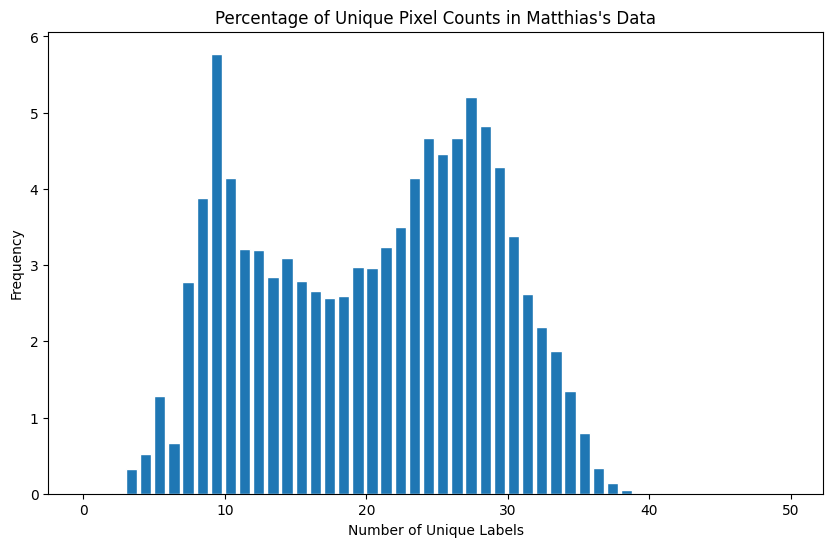

In [48]:
matth_num_slices = len(matthias_unique_labels)
bins = np.arange(0, 51, 1)
matth_hist_counts, matth_bin_edges = np.histogram(matthias_unique_labels,bins=bins)
# print(matth_hist_counts, matth_bin_edges)

# Plotting the histogram
matth_hist_percentages = [item / matth_num_slices * 100 for item in matth_hist_counts]
plt.figure(figsize=(10, 6))
plt.bar(matth_bin_edges[:-1], matth_hist_percentages, align='edge', edgecolor='white')

# Adding labels and title
plt.xlabel('Number of Unique Labels')
plt.ylabel('Frequency')
plt.title("Percentage of Unique Pixel Counts in Matthias's Data")

plt.show()

In [ ]:
my_unique_labels = []
for mask_file in my_masks[:1000]:
    mask = np.load(mask_file).astype(np.int16)
    unique_labels = mapping(np.array(np.unique(mask)))
    my_unique_labels.append(len(unique_labels))


In [11]:
all_my_masks = [np.load(mask_file).astype(np.int16) for mask_file in my_masks]

In [53]:
mask_unique_labels = list(map(np.unique,all_my_masks))

In [46]:
reference_col='original'
new_col='50-class'
class_mapping = {}
df = pd.read_csv("/om2/user/sabeen/nobrainer_data_norm/class_mapping.csv")
for value in df[reference_col].unique():
    filtered_rows = df[df[reference_col] == value]
    numbers = list(set(filtered_rows[new_col].tolist()))
    assert len(numbers) <= 1, "unique mapping does not exist"
    class_mapping[value] = numbers[0]

def len_mapping(mask,class_mapping):
    mask = np.array(mask)
    u = np.unique(mask)
    # num_classes = 50  # len(class_mapping)
    for x in u:
        if x not in class_mapping:
            # class_mapping[x] = nr_of_classes - 1
            class_mapping[x] = 0

    # we collect all classes not in the mapping table as an additional "other" class
    # mask = np.array([class_mapping[int(x)] if x in labels else len(labels) for x in u])[inv].reshape(mask.shape)
    for old, new in class_mapping.items():
        mask[mask == old] = -1 * new
    mask = mask * -1

    return len(np.unique(mask))

In [54]:
my_unique_labels = list(map(lambda x: len_mapping(x,class_mapping),mask_unique_labels))

In [55]:
max(my_unique_labels)

42

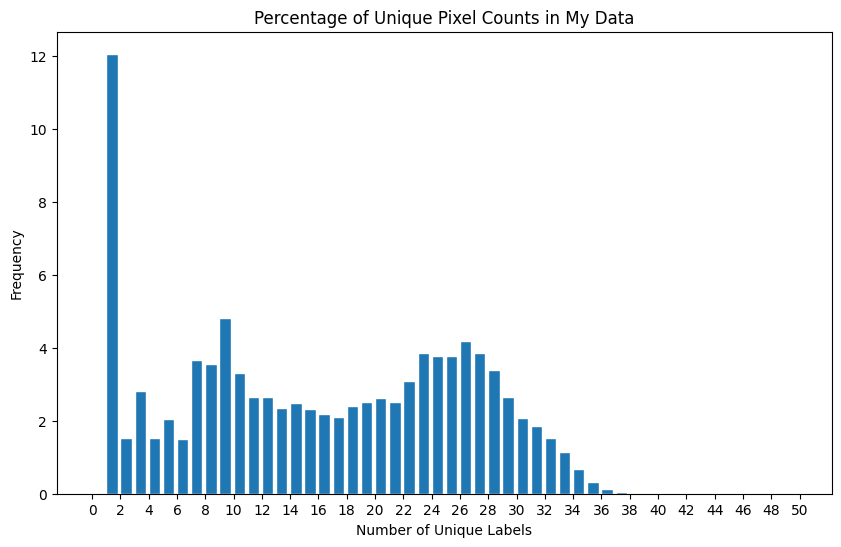

In [60]:
my_num_slices = len(my_unique_labels)
bins = np.arange(0, 51, 1)
my_hist_counts, my_bin_edges = np.histogram(my_unique_labels,bins=bins)

# Plotting the histogram
my_hist_percentages = [item / my_num_slices * 100 for item in my_hist_counts]
plt.figure(figsize=(10, 6))
plt.bar(my_bin_edges[:-1], my_hist_percentages, align='edge', edgecolor='white')

# Adding labels and title
plt.xlabel('Number of Unique Labels')
plt.xticks(np.arange(0, 51, step=2))
plt.ylabel('Frequency')
plt.title("Percentage of Unique Pixel Counts in My Data")

plt.show()

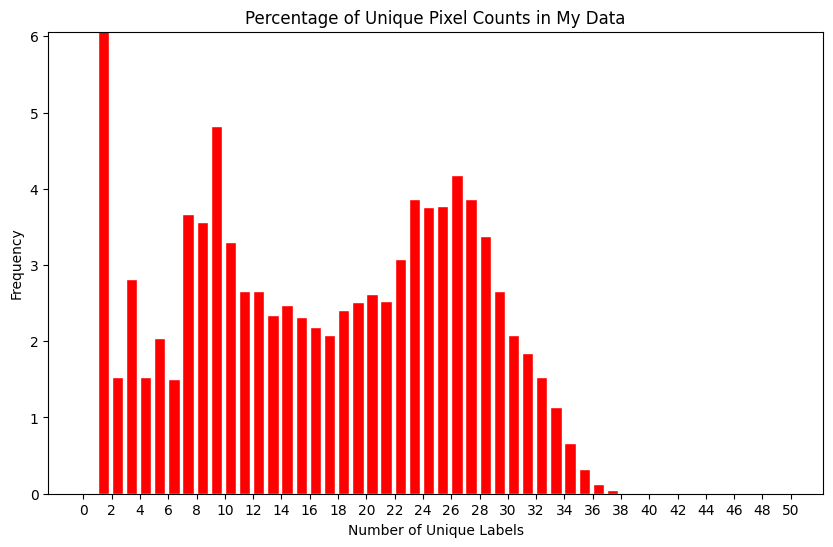

In [75]:
my_num_slices = len(my_unique_labels)
bins = np.arange(0, 51, 1)
my_hist_counts, my_bin_edges = np.histogram(my_unique_labels,bins=bins)

# Plotting the histogram
my_hist_percentages = [item / my_num_slices * 100 for item in my_hist_counts]
plt.figure(figsize=(10, 6))
plt.bar(my_bin_edges[:-1], my_hist_percentages, align='edge', color='red', edgecolor='white')

# Adding labels and title
plt.xlabel('Number of Unique Labels')
plt.xticks(np.arange(0, 51, step=2))
plt.ylabel('Frequency')
plt.ylim([0, 6.06])
plt.yticks(np.arange(0, 7, step=1))
plt.title("Percentage of Unique Pixel Counts in My Data")

plt.show()